# Natural Language Processing for the Fake News Challenge

## Main Imports

In [198]:
import torch
import string
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
pd.set_option('mode.chained_assignment', None)

from google.colab import drive
drive.mount('/content/drive')

import nltk
nltk.download('stopwords')
nltk.download('punkt')

from sklearn.base import TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc, f1_score

from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Bidirectional, LeakyReLU
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

!pip install transformers
import transformers

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Set up the data for preprocessing

### Load the data

In [ ]:
main_path = '/content/drive/My Drive/University Work/Year 4/Natural Language Processing/'
data_folder_name = 'data/'

train_body_filename = 'train_bodies.csv'
train_stance_filename = 'train_stances.csv'
test_body_filename = 'competition_test_bodies.csv'
test_stance_filename = 'competition_test_stances.csv'

train_body_path = main_path + data_folder_name + train_body_filename 
train_stance_path = main_path + data_folder_name + train_stance_filename
test_body_path = main_path + data_folder_name + test_body_filename
test_stance_path = main_path + data_folder_name + test_stance_filename

train_body_data = pd.read_csv(train_body_path)
train_stance_data = pd.read_csv(train_stance_path)
test_body_data = pd.read_csv(test_body_path)
test_stance_data = pd.read_csv(test_stance_path)

### Data Preprocessing

In [ ]:
def preprocess(text):

    text = nltk.tokenize.word_tokenize(text)
    text = [word for word in text if word not in nltk.corpus.stopwords.words('english')]
    text = (" ").join(text)

    table = str.maketrans('', '', string.punctuation)
    text = text.translate(table)

    ps = nltk.stem.PorterStemmer()
    text = nltk.tokenize.word_tokenize(text)

    text = [ps.stem(word) for word in text]
    text = (" ").join(text)

    return text

In [ ]:
train_body_data['articleBody'] = train_body_data['articleBody'].apply(lambda x: preprocess(x))
train_stance_data['Headline'] = train_stance_data['Headline'].apply(lambda x: preprocess(x))
test_body_data['articleBody'] = test_body_data['articleBody'].apply(lambda x: preprocess(x))
test_stance_data['Headline'] = test_stance_data['Headline'].apply(lambda x: preprocess(x))

### Merge the data based on the Body ID to get one dataframe containing the corresponding Headlines and Article Bodies with a Relevance column

In [ ]:
train_total_data = pd.merge(train_body_data, train_stance_data, on='Body ID')
train_total_data['Relevance'] = np.where(train_total_data['Stance'] == 'unrelated', 0, 1)

test_total_data = pd.merge(test_body_data, test_stance_data, on='Body ID')
test_total_data['Relevance'] = np.where(test_total_data['Stance'] == 'unrelated', 0, 1)

train_total_data.sample(10)

,Body ID,articleBody,Headline,Stance,Relevance
10646,649,A student broken 19year silenc reveal icon sun...,‘ teletubbi ’ sun babi fan freak out over jess...,agree,1
21078,1249,managua nicaragua — nicaragua ’ govern said su...,meteor leav 40foot crater near managua s airport,discuss,1
43438,2260,A humor report satir web site done style china...,unconfirm isi claim kayla mueller american fem...,unrelated,0
48655,2476,appl continu experi hairgat problem may public...,rumor robert plant rip Up 800 million contract...,unrelated,0
18055,1048,amazon reportedli plan launch adsupport media ...,canadianisra woman say she hasn ’ been captur ...,unrelated,0
45368,2328,thi possibl best resign letter I ’ ever seen N...,isi milit “ jihadi john ” identifi As young we...,unrelated,0
33472,1837,It seem like robot everywher day ’ roll around...,here are microsoft s new robot secur guard,agree,1
22933,1334,the imag show victim batter shopper worker pas...,shock moment show adulteress strip nake beaten...,agree,1
2358,125,islam state milit sympathis triumphantli circu...,mysteri man slap shopper around head sneez,unrelated,0
30416,1693,the fashion bibl ’ got decidedli unglamor rat ...,they ate ceil poop keyboard rat take vogu s ne...,discuss,1


### Splitting the dataset into training/validation/testing sets

In [ ]:
train_input_columns = train_total_data[['Headline', 'articleBody']]
target = 'Relevance'
X_train, X_val, y_train, y_val = train_test_split(train_input_columns, train_total_data[target].values, test_size=0.20, random_state=0)

X_test = test_total_data[['Headline', 'articleBody']]
y_test = test_total_data[['Relevance']].to_numpy().ravel()

# check the size of our datasets
print('Size of training set:', X_train.shape)
print('Size of validation set:', X_val.shape)
print('Size of testing set:', X_test.shape)

X_train.sample(10)

Size of training set: (39977, 2)
Size of validation set: (9995, 2)
Size of testing set: (25413, 2)


,Headline,articleBody
23008,michael phelp ’ alleg girlfriend say born inte...,high qualiti global journal requir invest plea...
18680,comcast say you can keep your tor,spot spider floor may give fright imagin find ...
32320,dylan thoma find tropic spider burrow under skin,It stori everyon paralys fear howev group spid...
41433,io 8 bug could delet icloud drive document,elect offici activist new york react posit cit...
45556,one gunman kill shoot parliament hill ottawa h...,australia — A man australia dub “ spider man ”...
7223,that wa fast christian bale bail steve job biopic,It less two week ago screenwrit aaron sorkin g...
43172,report alleg new audio michael brown shoot,the fbi allegedli interview man whose video ch...
18462,saudi arabia cleric issu fatwa against build s...,video user new iphon 6 say hair get caught scr...
44427,accus boston marathon bomber sever injur In pr...,pope franci suggest recent even anim place hea...
35386,boko haram ceasefir abduct nigerian schoolgirl...,london A pickup truck own plumb compani texa s...


## Evaluation Metrics

### Confusion Matrix

In [ ]:
# Create the confusion matrix
def plot_confusion_matrix(y_test, y_pred):
    ''' Plot the confusion matrix for the target labels and predictions '''
    cm = confusion_matrix(y_test, y_pred)

    # Create a dataframe with the confusion matrix values
    df_cm = pd.DataFrame(cm, range(cm.shape[0]),
                  range(cm.shape[1]))

    # Plot the confusion matrix
    sn.set(font_scale=1.4) #for label size
    sn.heatmap(df_cm, annot=True,fmt='.0f',cmap="YlGnBu",annot_kws={"size": 10})# font size
    plt.show()

### ROC Curve

In [ ]:
# ROC Curve
# Calculate the points in the ROC curve
def plot_roc_curve(y_test, y_pred):
    ''' Plot the ROC curve for the target labels and predictions'''
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    roc_auc= auc(fpr,tpr)
    plt.figure(figsize=(12, 12))
    ax = plt.subplot(121)
    ax.set_aspect(1)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

### Display Classification Accuracies over results and plot Confusion Matrix and ROC Curve results

In [ ]:
def display_results(y_pred, y_val):

    # print classification report and plot confusion matrix and ROC curve
    print(classification_report(y_val, y_pred))
    plot_confusion_matrix(y_val, y_pred)
    plot_roc_curve(y_val, y_pred)

## Feature Extraction

### TF-IDF Feature Extraction

#### Custom Transformer for Pipeline

In [170]:
# custom transformer for column extraction
class ColumnExtractor(TransformerMixin):

    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]

#### Pipelines and Feature Union of Headline and Article Body

In [171]:
min_df = 4
max_df = 0.5
max_features = 500

# create pipes and perform TF-IDF on Headline and Body columns
headline_pipe = make_pipeline(
    ColumnExtractor('Headline'),
    TfidfVectorizer(decode_error='ignore', min_df=min_df, max_df=max_df, max_features=max_features, lowercase=True)
)

body_pipe = make_pipeline(
    ColumnExtractor('articleBody'),
    TfidfVectorizer(decode_error='ignore', min_df=min_df, max_df=max_df, max_features=max_features, lowercase=True)
)

# combine headline and body transformers with a feature union and weight equally
preprocessor = FeatureUnion(transformer_list=[('headline', headline_pipe),
                                              ('body', body_pipe)],
                            transformer_weights= {
                                    'headline': 0.5,
                                    'body': 0.5
                               }
                           )

# fit transform and print data
tfidf_train = preprocessor.fit_transform(X_train).todense()
tfidf_val = preprocessor.transform(X_val).todense()
tfidf_test = preprocessor.transform(X_test).todense()
print('Train size:', tfidf_train.shape)
print('Val size:  ', tfidf_val.shape)
print('Test size: ', tfidf_test.shape)

Train size: (39977, 1000)
Val size:   (9995, 1000)
Test size:  (25413, 1000)


### BERT Embeddings Extraction

#### Load the model and tokeniser

In [ ]:
model_class, tokenizer_class, pretrained_weights = (transformers.DistilBertModel,
                                                    transformers.DistilBertTokenizer,
                                                    'distilbert-base-uncased')
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
bert_model = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#### Compute BERT Embeddings of Headline + Body pairs

In [ ]:
def get_bert_embeddings(bert_model, data, batch_size):

    # set device and lambda function for classification token retrieval
    device = torch.device("cuda")
    get_cls_token_embeddings = lambda x: x[0][:, 0, :].squeeze()
    bert_embeddings = []  # initialise embeddings

    for i in range(batch_size, data.shape[0] + batch_size, batch_size):
    
        if i % 100 == 0:
            print("Batch", i)

        # tokenise
        tokenized = tokenizer(list(data['Headline'][i - batch_size:i]), list(data['articleBody'][i - batch_size:i]),\
                          padding='max_length', truncation=True, return_tensors="pt")
        
        # get input ids and set to device
        tokenized_text = tokenized['input_ids']
        tokenized_text = tokenized_text.to(device)

        # calculate embeddings and retrieve cls token embedding
        with torch.no_grad():
            word_embeddings = bert_model(tokenized_text)
        cls_token_embeddings = get_cls_token_embeddings(word_embeddings)

        # append to total embeddings
        if bert_embeddings == []:
            bert_embeddings = cls_token_embeddings
        else:
            bert_embeddings = torch.cat((bert_embeddings, cls_token_embeddings), 0)

        # clear cache and GPU memory
        del word_embeddings
        torch.cuda.empty_cache()

    return bert_embeddings

#### Retrieve BERT Embeddings for train, validation and test sets

In [ ]:
def get_bert_embedding_sets(train, val, test, task):

    device = torch.device("cuda")
    bert_model = model_class.from_pretrained(pretrained_weights)
    bert_model = bert_model.to(device)
    batch_size = 256

    print("===Training Set===")
    bert_train = get_bert_embeddings(bert_model, train, batch_size)
    torch.save(bert_train, main_path + 'embeddings/' + task + 'bert_train.pt')

    print("===Validation Set===")
    bert_val = get_bert_embeddings(bert_model, val, batch_size)
    torch.save(bert_val, main_path + 'embeddings/bert_val.pt')

    print("===Testing Set===")
    bert_test = get_bert_embeddings(bert_model, test, batch_size)
    torch.save(bert_test, main_path + 'embeddings/' + task + 'bert_test.pt')

In [ ]:
get_bert_embedding_sets(X_train, X_val, X_test, '')

#### Load BERT Embeddings for train, validation and test sets

In [ ]:
# load, detach from GPU, and convert to numpy arrays
bert_train = torch.load(main_path + 'embeddings/bert_train.pt').detach().cpu().numpy()
bert_val = torch.load(main_path + 'embeddings/bert_val.pt').detach().cpu().numpy()
bert_test = torch.load(main_path + 'embeddings/bert_test.pt').detach().cpu().numpy()

## Related/Unrelated Classification

### Machine Learning Models

#### Train Random Forest (RF) Classifier using TF-IDF Features and display results

In [ ]:
tfidf_RF_model = RandomForestClassifier(random_state=0, max_features=150).fit(tfidf_train, y_train)
tfidf_RF_model.score(tfidf_test, y_test)

0.7569354267500885

              precision    recall  f1-score   support

           0       0.77      0.94      0.85     18349
           1       0.64      0.29      0.40      7064

    accuracy                           0.76     25413
   macro avg       0.71      0.61      0.62     25413
weighted avg       0.74      0.76      0.72     25413



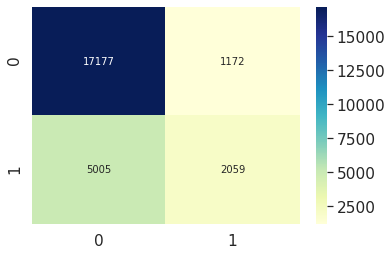

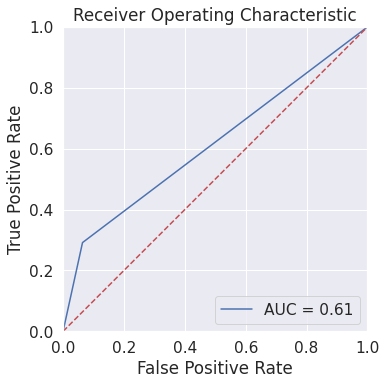

In [ ]:
y_pred = tfidf_RF_model.predict(tfidf_test)
display_results(y_pred, y_test)

#### Train Random Forest (RF) Classifier using BERT Embeddings and display results

In [ ]:
bert_RF_model = RandomForestClassifier(random_state=0, max_features=115).fit(bert_train, y_train)
bert_RF_model.score(bert_test, y_test)

0.6911816786683981

              precision    recall  f1-score   support

           0       0.74      0.88      0.81     18349
           1       0.39      0.19      0.26      7064

    accuracy                           0.69     25413
   macro avg       0.56      0.54      0.53     25413
weighted avg       0.64      0.69      0.65     25413



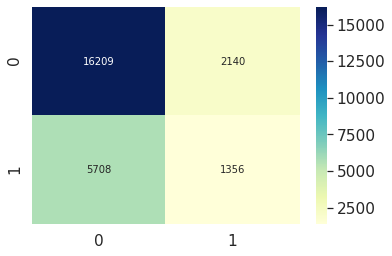

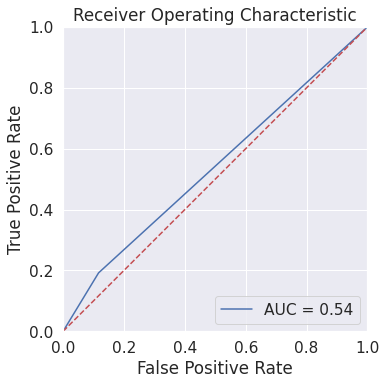

In [ ]:
y_pred = bert_RF_model.predict(bert_test)
display_results(y_pred, y_test)

### Deep Learning Models

#### Train a Multi-Layer Perceptron (MLP) on TF-IDF Embeddings

##### Define the MLP

In [ ]:
tfidf_MLP = Sequential()
tfidf_MLP.add(Dense(256, activation='relu', input_dim=1000))
tfidf_MLP.add(Dense(128, activation='relu'))
tfidf_MLP.add(Dense(64, activation='relu'))
tfidf_MLP.add(Dense(1, activation='sigmoid'))
tfidf_MLP.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy'])
print(tfidf_MLP.summary())

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             (None, 256)               256256    
_________________________________________________________________
dense_65 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_66 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_67 (Dense)             (None, 1)                 65        
Total params: 297,473
Trainable params: 297,473
Non-trainable params: 0
_________________________________________________________________
None


##### Train the MLP

In [ ]:
batch_size = 32
tfidf_MLP.fit(tfidf_train, y_train, batch_size=batch_size,
        epochs=10, validation_data=(tfidf_val, y_val))

Epoch 1/10
1250/1250 [==============================] - 5s 3ms/step - loss: 0.3258 - accuracy: 0.8544 - val_loss: 0.0542 - val_accuracy: 0.9802
Epoch 2/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.0221 - accuracy: 0.9923 - val_loss: 0.0434 - val_accuracy: 0.9836
Epoch 3/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.0106 - accuracy: 0.9966 - val_loss: 0.0410 - val_accuracy: 0.9870
Epoch 4/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.0097 - accuracy: 0.9969 - val_loss: 0.0362 - val_accuracy: 0.9871
Epoch 5/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.0072 - accuracy: 0.9977 - val_loss: 0.0357 - val_accuracy: 0.9886
Epoch 6/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.0047 - accuracy: 0.9989 - val_loss: 0.0405 - val_accuracy: 0.9892
Epoch 7/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.0046 - accuracy: 0.9987 - val_loss: 0.0417 - val_accuracy:

##### Display Results of MLP on Related/Unrelated Classification

              precision    recall  f1-score   support

           0       0.86      0.76      0.80     18349
           1       0.52      0.67      0.58      7064

    accuracy                           0.73     25413
   macro avg       0.69      0.71      0.69     25413
weighted avg       0.76      0.73      0.74     25413



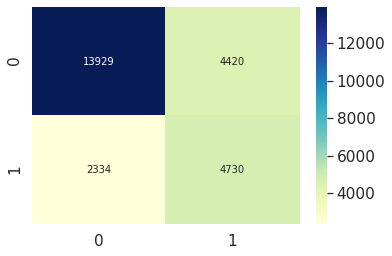

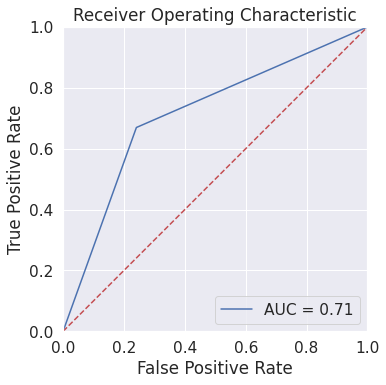

In [ ]:
y_pred = (tfidf_MLP.predict(tfidf_test) > 0.5).astype("int32")
display_results(y_pred, y_test)

#### Train a Bidirectional Long Short Term Memory (Bi-LSTM) model on BERT Embeddings

##### Define the LSTM

In [ ]:
# https://stackoverflow.com/questions/62281260/how-to-use-cnn-and-lstm-for-nlp-with-bert-embeddings
reshaped_bert_train = bert_train.reshape(-1, 768, 1)
reshaped_bert_val = bert_val.reshape(-1, 768, 1)

bert_LSTM = Sequential()
bert_LSTM.add(Bidirectional(LSTM(units=128, return_sequences=True), input_shape=(768, 1)))
bert_LSTM.add(Bidirectional(LSTM(units=64)))
bert_LSTM.add(Dense(256, activation='relu'))
bert_LSTM.add(LeakyReLU(alpha=0.05))
bert_LSTM.add(Dense(128, activation='relu'))
bert_LSTM.add(LeakyReLU(alpha=0.05))
bert_LSTM.add(Dense(1, activation='sigmoid'))

optimizer = Adam(lr=0.001)

bert_LSTM.compile(optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=['accuracy'])
bert_LSTM.summary()

torch.Size([131072, 768, 1])
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 768, 256)          133120    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               164352    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               33024     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)          

##### Train the LSTM

In [ ]:
batch_size = 32
unrelated, related = np.bincount(train_total_data['Relevance'])
total = unrelated + related

# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

unrelated_weight = (1 / unrelated)*(total)/2.0 
related_weight = (1 / related)*(total)/2.0
class_weights = {0: unrelated_weight, 1: related_weight}

model_save_file = main_path + "models/new_bert_LSTM.hdf5"
checkpoint = ModelCheckpoint(model_save_file, monitor='loss', verbose=1,
    save_best_only=True, mode='auto', save_freq=10000)

history = bert_LSTM.fit(reshaped_bert_train, y_train, batch_size=batch_size,
                        epochs=200, validation_data=(reshaped_bert_val, y_val),
                        callbacks=[checkpoint], class_weight=class_weights)

Epoch 1/200
1250/1250 [==============================] - 190s 136ms/step - loss: 0.6934 - accuracy: 0.5093 - val_loss: 0.7076 - val_accuracy: 0.2768
Epoch 2/200
1250/1250 [==============================] - 173s 138ms/step - loss: 0.6895 - accuracy: 0.5475 - val_loss: 0.6832 - val_accuracy: 0.5696
Epoch 3/200
1250/1250 [==============================] - 173s 138ms/step - loss: 0.6813 - accuracy: 0.5971 - val_loss: 0.6764 - val_accuracy: 0.6366
Epoch 4/200
1250/1250 [==============================] - 171s 137ms/step - loss: 0.6809 - accuracy: 0.6064 - val_loss: 0.6824 - val_accuracy: 0.6098
Epoch 5/200
1250/1250 [==============================] - 175s 140ms/step - loss: 0.6784 - accuracy: 0.6267 - val_loss: 0.6588 - val_accuracy: 0.6804
Epoch 6/200
1250/1250 [==============================] - 175s 140ms/step - loss: 0.6748 - accuracy: 0.6521 - val_loss: 0.6855 - val_accuracy: 0.6420
Epoch 7/200
1250/1250 [==============================] - 174s 139ms/step - loss: 0.6764 - accuracy: 0.6138

##### Display Results of LSTM on Related/Unrelated Classification

              precision    recall  f1-score   support

           0       0.76      0.68      0.72     18349
           1       0.35      0.45      0.39      7064

    accuracy                           0.61     25413
   macro avg       0.55      0.56      0.55     25413
weighted avg       0.65      0.61      0.63     25413



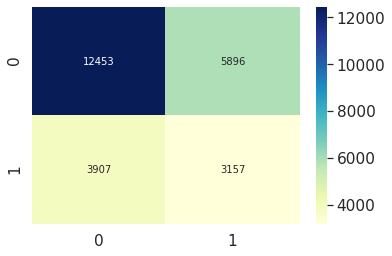

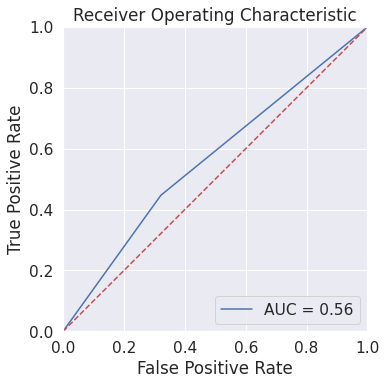

In [ ]:
reshaped_bert_test = bert_test.reshape(-1, 768, 1)
bert_LSTM = load_model(main_path + "models/new_bert_LSTM.hdf5")
y_pred = (bert_LSTM.predict(reshaped_bert_test) > 0.5).astype("int32")
display_results(y_pred, y_test)

## Agree/Disagree/Discuss Classification

### Setting up the data

#### Select the related Headline-Body pairs and convert to integers

In [204]:
train_related_data = train_total_data[train_total_data['Relevance'] == 1]

labels = {
    'discuss': 0,
    'agree': 1,
    'disagree': 2
}

train_related_data['Stance'] = train_related_data['Stance'].map(labels)

test_related_data = test_total_data[test_total_data['Relevance'] == 1]
test_related_data['Stance'] = test_related_data['Stance'].map(labels)

#### Split the related data into training/validation/testing sets

In [205]:
train_input_columns_related = train_related_data[['Headline', 'articleBody']]
target = 'Stance'

X_train_related, X_val_related, y_train_related, y_val_related = train_test_split(train_input_columns_related, train_related_data[target].values, test_size=0.2, random_state=0)
y_train_related = to_categorical(y_train_related)
y_val_related = to_categorical(y_val_related)

X_test_related = test_related_data[['Headline', 'articleBody']]
y_test_related = test_related_data[['Stance']].to_numpy().ravel()
y_test_related = to_categorical(y_test_related)

print('Size of training set:  ', X_train_related.shape)
print('Size of validation set:', X_val_related.shape)
print('Size of testing set:   ', X_test_related.shape)

X_train.sample(10)

Size of training set:   (10741, 2)
Size of validation set: (2686, 2)
Size of testing set:    (7064, 2)


,Headline,articleBody
3409,20yearold burger mcdonald s quarter pounder lo...,christian bale play steve job the hollywood re...
6817,break britishborn hostag kill fail rescu attempt,the sister britishborn american photojournalis...
26768,nbc weatherman caught urin wood live air,baghdad iraq – the islam state isi inciner cor...
23390,christian bale pass role steve job actor repor...,A woman claim girlfriend olymp swimmer michael...
37714,20 year old burger mcdonald s burger purchas 1...,A texa plumber left bewild truck sold last yea...
9449,thank uncl sam weapon airdrop isi taunt americ...,As feelgood video gener homeless man continu t...
32637,Is alleg audio gunshot that kill michael brown...,We re two month away appl watch launch thing s...
35417,boko haram to releas abduct schoolgirl part ce...,london A pickup truck own plumb compani texa s...
25522,miss libyan jetlin rais fear suicid airlin att...,A rogu bird let loos vladimir putin weekend ru...
3400,moment michael brown shot dead caught audio re...,A video post isil terrorist iraq purport show ...


### Feature Extraction

#### Compute and save BERT embeddings of train/val/test data

In [ ]:
get_bert_embedding_sets(X_train_related, X_val_related, X_test_related, 'related_')

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


===Training Set===
Batch 6400
===Validation Set===
===Testing Set===
Batch 6400


#### Load BERT Embeddings

In [ ]:
bert_train_related = torch.load(main_path + 'embeddings/related_bert_train.pt').detach().cpu().numpy()
bert_val_related = torch.load(main_path + 'embeddings/related_bert_val.pt').detach().cpu().numpy()
bert_test_related = torch.load(main_path + 'embeddings/related_bert_test.pt').detach().cpu().numpy()

### Train a Bidirectional LSTM on BERT Embeddings 

In [181]:
reshaped_bert_train = bert_train_related.reshape(-1, 768, 1)
reshaped_bert_val = bert_val_related.reshape(-1, 768, 1)

bert_LSTM_related = Sequential()
bert_LSTM_related.add(Bidirectional(LSTM(units=128), input_shape=(768, 1)))
bert_LSTM_related.add(Dense(128))
bert_LSTM_related.add(LeakyReLU(alpha=0.05))
bert_LSTM_related.add(Dense(3, activation='softmax'))

optimizer = Adam(lr=0.001)

bert_LSTM_related.compile(optimizer=optimizer,
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])
bert_LSTM_related.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_33 (Bidirectio (None, 256)               133120    
_________________________________________________________________
dense_55 (Dense)             (None, 128)               32896     
_________________________________________________________________
leaky_re_lu_33 (LeakyReLU)   (None, 128)               0         
_________________________________________________________________
dense_56 (Dense)             (None, 3)                 387       
Total params: 166,403
Trainable params: 166,403
Non-trainable params: 0
_________________________________________________________________


In [194]:
batch_size = 32
discuss, agree, disagree = np.bincount(related_data['Stance'])
total = agree + disagree + discuss

agree_weight = (1 / agree)*(total)/2.0 
disagree_weight = (1 / disagree)*(total)/2.0
discuss_weight = (1 / discuss)*(total)/2.0

class_weights = {0: discuss_weight, 1: agree_weight, 2: disagree_weight}

model_save_file = main_path + "models/agree_disagree_LSTM.hdf5"
checkpoint = ModelCheckpoint(model_save_file, monitor='loss', verbose=1,
    save_best_only=True, mode='auto', save_freq=8400)

history = bert_LSTM_related.fit(reshaped_bert_train, y_train_related, batch_size=batch_size,
                        epochs=50, validation_data=(reshaped_bert_val, y_val_related),
                        callbacks=[checkpoint], class_weight=class_weights)

discuss: 8909 agree: 3678 disagree 840
0.7535638118756314 1.8253126699293092 7.9922619047619055
Epoch 1/50
336/336 [==============================] - 25s 75ms/step - loss: 1.4497 - accuracy: 0.5443 - val_loss: 0.9470 - val_accuracy: 0.5767
Epoch 2/50
336/336 [==============================] - 25s 74ms/step - loss: 1.4148 - accuracy: 0.5472 - val_loss: 0.9346 - val_accuracy: 0.5599
Epoch 3/50
336/336 [==============================] - 25s 74ms/step - loss: 1.3836 - accuracy: 0.5634 - val_loss: 0.8548 - val_accuracy: 0.5812
Epoch 4/50
336/336 [==============================] - 25s 74ms/step - loss: 1.3522 - accuracy: 0.5772 - val_loss: 0.9328 - val_accuracy: 0.5551
Epoch 5/50
336/336 [==============================] - 25s 74ms/step - loss: 1.3274 - accuracy: 0.5834 - val_loss: 1.0067 - val_accuracy: 0.4859
Epoch 6/50
336/336 [==============================] - 25s 74ms/step - loss: 1.3061 - accuracy: 0.5875 - val_loss: 0.8173 - val_accuracy: 0.6270
Epoch 7/50
336/336 [====================

              precision    recall  f1-score   support

           0       0.70      0.59      0.64      4464
           1       0.32      0.42      0.37      1903
           2       0.11      0.13      0.12       697

    accuracy                           0.50      7064
   macro avg       0.38      0.38      0.38      7064
weighted avg       0.54      0.50      0.52      7064



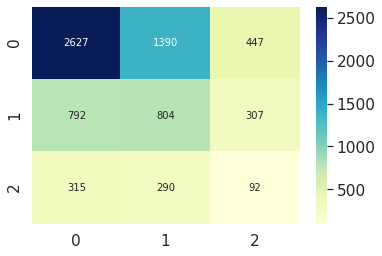

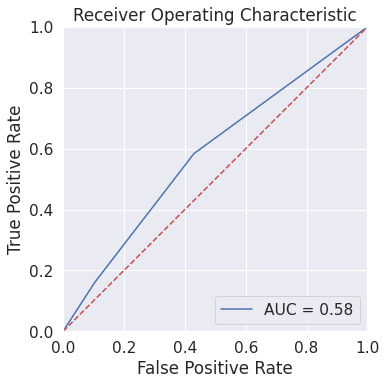

In [206]:
reshaped_bert_test = bert_test_related.reshape(-1, 768, 1)
#bert_LSTM_related = load_model(main_path + "models/new_bert_LSTM.hdf5")
y_pred = (bert_LSTM_related.predict(reshaped_bert_test) > 0.5).astype("int32")
display_results(y_pred.argmax(axis=1), y_test_related.argmax(axis=1))